# 0. Import libraries

The libraries used to create the data are in the following cell

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LearningRateScheduler,TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

2023-09-26 12:07:43.770885: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 12:07:44.351202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 1. Define constants

This section defines constants to be used in the notebook

In [10]:
# Path constants
MODELS_FOLDER_PATH = "./Models"
MODEL_NAME = "linear.keras"
MODEL_FILE_PATH = f"{MODELS_FOLDER_PATH}/{MODEL_NAME}"

DATA_FOLDER_PATH = "./Data"
FEATURES_FILENAME = "surfaces_linear.npy"
LABELS_FILENAME = "coefficients_linear.npy"

FEATURES_FILE_PATH = f"{DATA_FOLDER_PATH}/{FEATURES_FILENAME}"
LABELS_FILE_PATH = f"{DATA_FOLDER_PATH}/{LABELS_FILENAME}"

# Neural network architecture size
INPUT_SIZE = 60
OUTPUT_SIZE = 21

# Neural network training parameters
N_EPOCHS = 750
BATCH_SIZE = 512
LEARNING_RATE = 0.01
ACTIVATION = 'relu'
N_HIDDEN = [512, 256, 64]
REGULARIZER = keras.regularizers.L1L2(l1=0.001,l2=0.1)
INITIALIZER = keras.initializers.he_normal(seed=None)
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
METRICS = tf.keras.metrics.MeanSquaredError()

# 2. Compile functions

In [3]:



def compile_model(my_model):
    my_model.compile(loss=LOSS,
                     optimizer=OPTIMIZER,
                     metrics=[METRICS])
    

# 2. Read data

First read the data

In [13]:
features = np.load(FEATURES_FILE_PATH, allow_pickle=True)
labels = np.load(LABELS_FILE_PATH, allow_pickle=True)

print(features[0])
print(features[0].shape)

[ -8.39383239   4.63206605  -3.40372399 -11.43289807  -9.78592245
   7.79446497  13.80637545  10.42003563  -0.68846479  -4.85242145
  -6.89663157 -15.98099397  -9.55387278   7.81798633  15.27930472
  16.02547998  17.03824683  11.15529101   1.35226392  -0.21393115
   3.29505405   5.12683266  -4.39412802 -16.8947901   -6.40595351
   7.10792499  14.20812504  13.30327085  11.73678549  14.74221583
  15.57764613   7.90812608   1.52797699   2.59635659   2.35661155
   2.59665656  11.27750216  14.78280535   1.12558506 -11.63307734
   1.76954211   6.06168866  10.55270508  13.71732192  13.77901304
  11.42234026  11.11232108  11.61531111   6.11679928  -2.34993745
  -2.13128969   3.33899025  -5.43828551 -29.62781926 -40.01049631
 -17.00429266  17.71555496  30.15317853  17.85303745   3.99212013]
(60,)


Split the data:
- **80%** training
- **10%** validation/dev test
- **10%** final test

In [5]:
# Calculate the number of rows for each split
total_rows = len(features)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)

# Split the DataFrame into training (80%), validation (10%), and test (10%)
train_features = features[:train_size]
train_labels = labels[:train_size]

val_features = features[train_size:train_size + val_size]
val_labels = labels[train_size:train_size + val_size]

test_features = features[train_size + val_size:]
test_labels = labels[train_size + val_size:]

# 3. Train neural network

Create the neural network architecture and compile it

In [6]:
surface_reconstruction_model, model_name = create_architecture()
compile_model(surface_reconstruction_model)

Define the callbacks

In [7]:
reduce_lr = ReduceLROnPlateau('mean_squared_error', factor=0.1, patience=150, verbose=1)
early_stop = EarlyStopping('mean_squared_error', patience=500, verbose=1)
callbacks = [reduce_lr, early_stop]

In [8]:
history = surface_reconstruction_model.fit(train_features,
                                           train_labels,
                                           batch_size=BATCH_SIZE,
                                           epochs=N_EPOCHS,
                                           validation_data= (val_features, val_labels),
                                           callbacks=callbacks,
                                           verbose=1)

Epoch 1/750


2023-09-26 12:07:47.097058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-26 12:07:47.100327: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1ba0cf30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-26 12:07:47.100349: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-09-26 12:07:47.104412: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-26 12:07:47.236597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-26 12:07:47.333148: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime o

94/94 [==============================] - 3s 8ms/step - loss: 28.1555 - mean_squared_error: 8.8899 - val_loss: 15.2889 - val_mean_squared_error: 11.8068 - lr: 0.0100
Epoch 2/750
94/94 [==============================] - 1s 6ms/step - loss: 6.2652 - mean_squared_error: 3.5698 - val_loss: 11.1095 - val_mean_squared_error: 8.9314 - lr: 0.0100
Epoch 3/750
94/94 [==============================] - 1s 6ms/step - loss: 5.0678 - mean_squared_error: 3.1486 - val_loss: 7.8948 - val_mean_squared_error: 6.2091 - lr: 0.0100
Epoch 4/750
94/94 [==============================] - 0s 4ms/step - loss: 4.3917 - mean_squared_error: 2.8863 - val_loss: 6.0828 - val_mean_squared_error: 4.7774 - lr: 0.0100
Epoch 5/750
94/94 [==============================] - 0s 4ms/step - loss: 3.9326 - mean_squared_error: 2.7298 - val_loss: 5.0314 - val_mean_squared_error: 3.8008 - lr: 0.0100
Epoch 6/750
94/94 [==============================] - 1s 7ms/step - loss: 3.6318 - mean_squared_error: 2.5825 - val_loss: 5.5959 - val_mean

Epoch 48/750
94/94 [==============================] - 1s 8ms/step - loss: 2.5411 - mean_squared_error: 2.0317 - val_loss: 4.1197 - val_mean_squared_error: 3.6180 - lr: 0.0100
Epoch 49/750
94/94 [==============================] - 1s 8ms/step - loss: 2.5638 - mean_squared_error: 2.0459 - val_loss: 5.4104 - val_mean_squared_error: 4.8921 - lr: 0.0100
Epoch 50/750
94/94 [==============================] - 1s 7ms/step - loss: 2.5351 - mean_squared_error: 2.0270 - val_loss: 6.3795 - val_mean_squared_error: 5.8616 - lr: 0.0100
Epoch 51/750
94/94 [==============================] - 1s 8ms/step - loss: 2.5482 - mean_squared_error: 2.0312 - val_loss: 5.8122 - val_mean_squared_error: 5.3271 - lr: 0.0100
Epoch 52/750
94/94 [==============================] - 1s 8ms/step - loss: 2.5392 - mean_squared_error: 2.0294 - val_loss: 9.5033 - val_mean_squared_error: 8.9786 - lr: 0.0100
Epoch 53/750
94/94 [==============================] - 1s 7ms/step - loss: 2.5436 - mean_squared_error: 2.0266 - val_loss: 4.8

94/94 [==============================] - 1s 8ms/step - loss: 2.3584 - mean_squared_error: 1.9075 - val_loss: 17.4113 - val_mean_squared_error: 16.9696 - lr: 0.0100
Epoch 141/750
94/94 [==============================] - 1s 8ms/step - loss: 2.3851 - mean_squared_error: 1.9235 - val_loss: 18.0803 - val_mean_squared_error: 17.6244 - lr: 0.0100
Epoch 142/750
94/94 [==============================] - 1s 8ms/step - loss: 2.3616 - mean_squared_error: 1.9082 - val_loss: 17.0982 - val_mean_squared_error: 16.6626 - lr: 0.0100
Epoch 143/750
94/94 [==============================] - 1s 7ms/step - loss: 2.3763 - mean_squared_error: 1.9210 - val_loss: 18.7607 - val_mean_squared_error: 18.3201 - lr: 0.0100
Epoch 144/750
94/94 [==============================] - 1s 8ms/step - loss: 2.3771 - mean_squared_error: 1.9255 - val_loss: 30.3189 - val_mean_squared_error: 29.8622 - lr: 0.0100
Epoch 145/750
94/94 [==============================] - 1s 7ms/step - loss: 2.3674 - mean_squared_error: 1.9133 - val_loss: 2

94/94 [==============================] - 1s 7ms/step - loss: 2.3463 - mean_squared_error: 1.9041 - val_loss: 17.4573 - val_mean_squared_error: 17.0260 - lr: 0.0100
Epoch 233/750
94/94 [==============================] - 1s 7ms/step - loss: 2.3496 - mean_squared_error: 1.9060 - val_loss: 14.0205 - val_mean_squared_error: 13.5931 - lr: 0.0100
Epoch 234/750
94/94 [==============================] - 1s 7ms/step - loss: 2.3564 - mean_squared_error: 1.9129 - val_loss: 44.8760 - val_mean_squared_error: 44.4426 - lr: 0.0100
Epoch 235/750
94/94 [==============================] - 1s 8ms/step - loss: 2.3782 - mean_squared_error: 1.9252 - val_loss: 17.4221 - val_mean_squared_error: 16.9696 - lr: 0.0100
Epoch 236/750
94/94 [==============================] - 1s 8ms/step - loss: 2.3436 - mean_squared_error: 1.9023 - val_loss: 12.1925 - val_mean_squared_error: 11.7494 - lr: 0.0100
Epoch 237/750
94/94 [==============================] - 1s 7ms/step - loss: 2.3579 - mean_squared_error: 1.9141 - val_loss: 1

94/94 [==============================] - 1s 6ms/step - loss: 2.3502 - mean_squared_error: 1.9139 - val_loss: 13.1369 - val_mean_squared_error: 12.7032 - lr: 0.0100
Epoch 325/750
94/94 [==============================] - 1s 7ms/step - loss: 2.3364 - mean_squared_error: 1.9046 - val_loss: 12.4199 - val_mean_squared_error: 11.9859 - lr: 0.0100
Epoch 326/750
94/94 [==============================] - 1s 6ms/step - loss: 2.3460 - mean_squared_error: 1.9094 - val_loss: 11.5850 - val_mean_squared_error: 11.1464 - lr: 0.0100
Epoch 327/750
94/94 [==============================] - 1s 7ms/step - loss: 2.3464 - mean_squared_error: 1.9079 - val_loss: 14.3247 - val_mean_squared_error: 13.9065 - lr: 0.0100
Epoch 328/750
94/94 [==============================] - 1s 5ms/step - loss: 2.3415 - mean_squared_error: 1.9086 - val_loss: 20.9947 - val_mean_squared_error: 20.5672 - lr: 0.0100
Epoch 329/750
94/94 [==============================] - 1s 6ms/step - loss: 2.3349 - mean_squared_error: 1.8993 - val_loss: 1

94/94 [==============================] - 1s 8ms/step - loss: 2.3314 - mean_squared_error: 1.9030 - val_loss: 16.8507 - val_mean_squared_error: 16.4254 - lr: 0.0100
Epoch 417/750
94/94 [==============================] - 1s 7ms/step - loss: 2.3573 - mean_squared_error: 1.9098 - val_loss: 21.7354 - val_mean_squared_error: 21.3097 - lr: 0.0100
Epoch 418/750
94/94 [==============================] - 1s 8ms/step - loss: 2.3345 - mean_squared_error: 1.9081 - val_loss: 22.4749 - val_mean_squared_error: 22.0508 - lr: 0.0100
Epoch 419/750
94/94 [==============================] - 1s 7ms/step - loss: 2.3412 - mean_squared_error: 1.9128 - val_loss: 26.2722 - val_mean_squared_error: 25.8430 - lr: 0.0100
Epoch 420/750
94/94 [==============================] - 1s 7ms/step - loss: 2.3300 - mean_squared_error: 1.9021 - val_loss: 18.0465 - val_mean_squared_error: 17.6214 - lr: 0.0100
Epoch 421/750
94/94 [==============================] - 1s 7ms/step - loss: 2.3401 - mean_squared_error: 1.9106 - val_loss: 2

94/94 [==============================] - 1s 7ms/step - loss: 2.3193 - mean_squared_error: 1.8955 - val_loss: 9.2533 - val_mean_squared_error: 8.8258 - lr: 0.0100
Epoch 509/750
94/94 [==============================] - 1s 7ms/step - loss: 2.3347 - mean_squared_error: 1.9108 - val_loss: 27.2678 - val_mean_squared_error: 26.8263 - lr: 0.0100
Epoch 510/750
94/94 [==============================] - 1s 8ms/step - loss: 2.3597 - mean_squared_error: 1.9277 - val_loss: 61.2131 - val_mean_squared_error: 60.7366 - lr: 0.0100
Epoch 511/750
94/94 [==============================] - 1s 8ms/step - loss: 2.3233 - mean_squared_error: 1.8972 - val_loss: 57.3373 - val_mean_squared_error: 56.8905 - lr: 0.0100
Epoch 512/750
94/94 [==============================] - 1s 8ms/step - loss: 2.3486 - mean_squared_error: 1.8912 - val_loss: 24.1375 - val_mean_squared_error: 23.7304 - lr: 0.0100
Epoch 513/750
94/94 [==============================] - 1s 6ms/step - loss: 2.3254 - mean_squared_error: 1.9051 - val_loss: 17.

94/94 [==============================] - 1s 8ms/step - loss: 2.3121 - mean_squared_error: 1.8973 - val_loss: 23.9968 - val_mean_squared_error: 23.5945 - lr: 0.0100
Epoch 601/750
94/94 [==============================] - 1s 8ms/step - loss: 2.3199 - mean_squared_error: 1.8995 - val_loss: 26.5999 - val_mean_squared_error: 26.1996 - lr: 0.0100
Epoch 602/750
94/94 [==============================] - 1s 7ms/step - loss: 2.3315 - mean_squared_error: 1.9033 - val_loss: 23.2221 - val_mean_squared_error: 22.8227 - lr: 0.0100
Epoch 603/750
94/94 [==============================] - 1s 7ms/step - loss: 2.3091 - mean_squared_error: 1.8879 - val_loss: 16.2822 - val_mean_squared_error: 15.8824 - lr: 0.0100
Epoch 604/750
94/94 [==============================] - 1s 8ms/step - loss: 2.3243 - mean_squared_error: 1.9070 - val_loss: 28.3889 - val_mean_squared_error: 27.9866 - lr: 0.0100
Epoch 605/750
94/94 [==============================] - 1s 7ms/step - loss: 2.3569 - mean_squared_error: 1.9194 - val_loss: 4

Epoch 645/750
94/94 [==============================] - 1s 7ms/step - loss: 1.7815 - mean_squared_error: 1.7214 - val_loss: 4.4305 - val_mean_squared_error: 4.3660 - lr: 1.0000e-03
Epoch 646/750
94/94 [==============================] - 1s 7ms/step - loss: 1.7778 - mean_squared_error: 1.7182 - val_loss: 4.0297 - val_mean_squared_error: 3.9769 - lr: 1.0000e-03
Epoch 647/750
94/94 [==============================] - 1s 6ms/step - loss: 1.7780 - mean_squared_error: 1.7189 - val_loss: 4.7657 - val_mean_squared_error: 4.7055 - lr: 1.0000e-03
Epoch 648/750
94/94 [==============================] - 1s 5ms/step - loss: 1.7806 - mean_squared_error: 1.7220 - val_loss: 4.2561 - val_mean_squared_error: 4.1974 - lr: 1.0000e-03
Epoch 649/750
94/94 [==============================] - 1s 6ms/step - loss: 1.7784 - mean_squared_error: 1.7204 - val_loss: 5.0330 - val_mean_squared_error: 4.9703 - lr: 1.0000e-03
Epoch 650/750
94/94 [==============================] - 1s 6ms/step - loss: 1.7741 - mean_squared_err

Epoch 736/750
94/94 [==============================] - 1s 7ms/step - loss: 1.7737 - mean_squared_error: 1.7201 - val_loss: 4.3587 - val_mean_squared_error: 4.3116 - lr: 1.0000e-03
Epoch 737/750
94/94 [==============================] - 1s 8ms/step - loss: 1.7710 - mean_squared_error: 1.7174 - val_loss: 4.1355 - val_mean_squared_error: 4.0810 - lr: 1.0000e-03
Epoch 738/750
94/94 [==============================] - 1s 7ms/step - loss: 1.7738 - mean_squared_error: 1.7207 - val_loss: 4.7633 - val_mean_squared_error: 4.7097 - lr: 1.0000e-03
Epoch 739/750
94/94 [==============================] - 1s 7ms/step - loss: 1.7694 - mean_squared_error: 1.7157 - val_loss: 4.5392 - val_mean_squared_error: 4.4803 - lr: 1.0000e-03
Epoch 740/750
94/94 [==============================] - 1s 8ms/step - loss: 1.7757 - mean_squared_error: 1.7223 - val_loss: 3.1606 - val_mean_squared_error: 3.1097 - lr: 1.0000e-03
Epoch 741/750
94/94 [==============================] - 1s 8ms/step - loss: 1.7711 - mean_squared_err

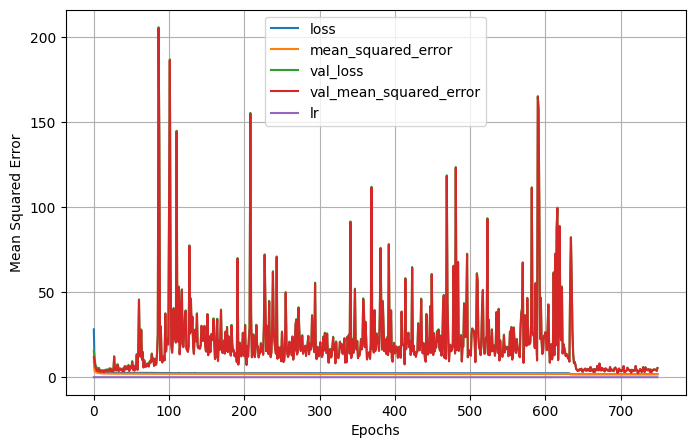

In [9]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Mean Squared Error")
plt.show()

In [14]:
surface_reconstruction_model.save(MODEL_FILE_PATH)